# BBC News Classification — EDA Notebook

This notebook performs exploratory data analysis (EDA) for a BBC news headline/topic classification dataset.

**Expected columns** in your CSV:
- `text`: the headline/content text
- `category`: the label (e.g., business/entertainment/politics/sport/tech)

> If your column names differ, change them in the **Load Data** section.


In [1]:
# --- Imports ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Make plots a bit sharper in notebooks
plt.rcParams["figure.dpi"] = 120


## 1) Load Data
Set `DATA_PATH` to your dataset CSV. Then load and do a quick sanity check.


In [2]:
# --- Load your dataset ---
# Option A: set a local path directly
DATA_PATH = "/home/mywsl/Workspace/NLP/data/bbc_text_cls.csv"   # <-- change if needed

# Option B: if you are using your Config class, you can do:
# from src.config import Config
# DATA_PATH = str(Config().dataset_csv)

df = pd.read_csv(DATA_PATH)
df.head()


text    labels
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business
2  Yukos unit buyer faces loan claim\n\nThe owner...  business
3  High fuel prices hit BA's profits\n\nBritish A...  business
4  Pernod takeover talk lifts Domecq\n\nShares in...  business

In [3]:
# --- Basic info ---
print("Shape:", df.shape)
print(df.dtypes)
print("\nMissing values:\n", df.isna().sum())


Shape: (2225, 2)
text      object
labels    object
dtype: object

Missing values:
 text      0
labels    0
dtype: int64


### (Optional) Rename columns
If your CSV uses different column names, map them here.


In [4]:
# If needed, uncomment and adjust:
# df = df.rename(columns={"headline": "text", "label": "category"})
# assert "text" in df.columns and "category" in df.columns, "CSV must contain columns: text, category"


## 2) Class Distribution
Check whether categories are balanced. This informs whether to use accuracy vs. macro-F1, and whether class weights are needed.


In [5]:
class_counts = df["labels"].value_counts()
class_counts


labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

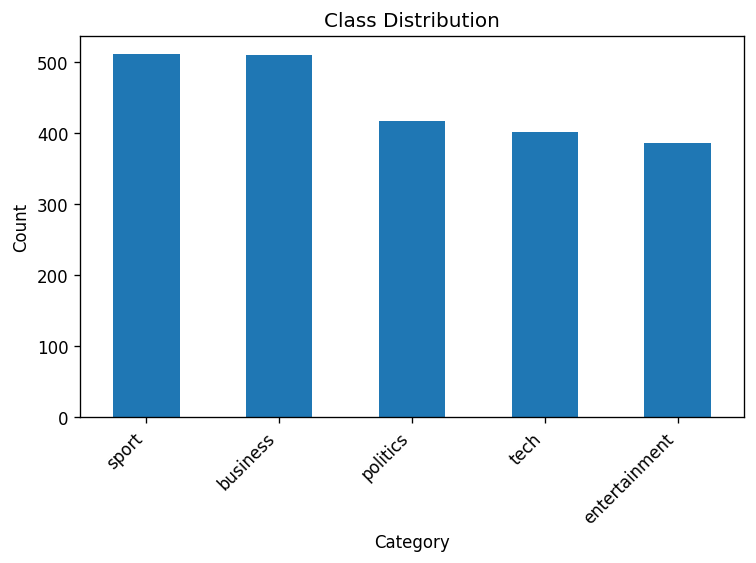

In [6]:
plt.figure()
class_counts.sort_values(ascending=False).plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 3) Text Length Analysis
Headline length affects modeling choices (e.g., TF-IDF often works extremely well on short texts).

We compute:
- character length
- whitespace token count


In [7]:
df["char_len"] = df["text"].astype(str).apply(len)
df["tok_len"] = df["text"].astype(str).apply(lambda x: len(x.split()))

df[["char_len", "tok_len"]].describe().T


count         mean          std    min     25%     50%     75%  \
char_len  2225.0  2264.157753  1364.095679  502.0  1447.0  1966.0  2803.0   
tok_len   2225.0   384.040449   238.174497   89.0   246.0   332.0   471.0   

              max  
char_len  25484.0  
tok_len    4432.0

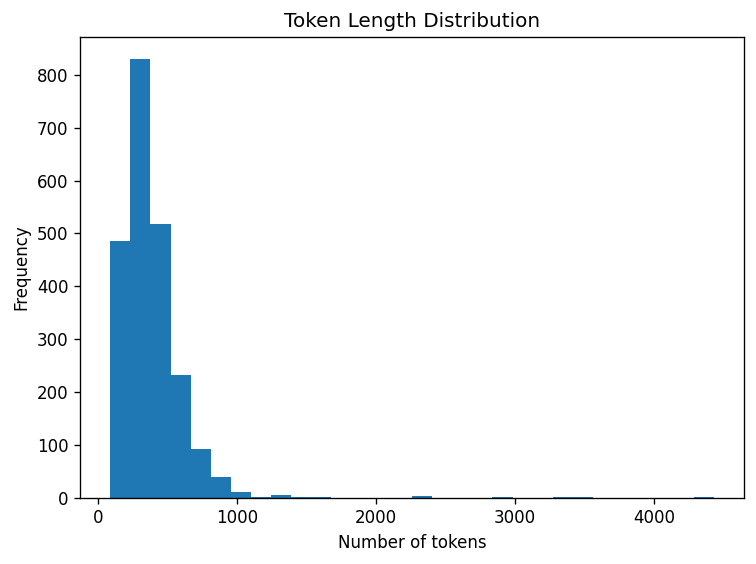

In [8]:
plt.figure()
plt.hist(df["tok_len"], bins=30)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


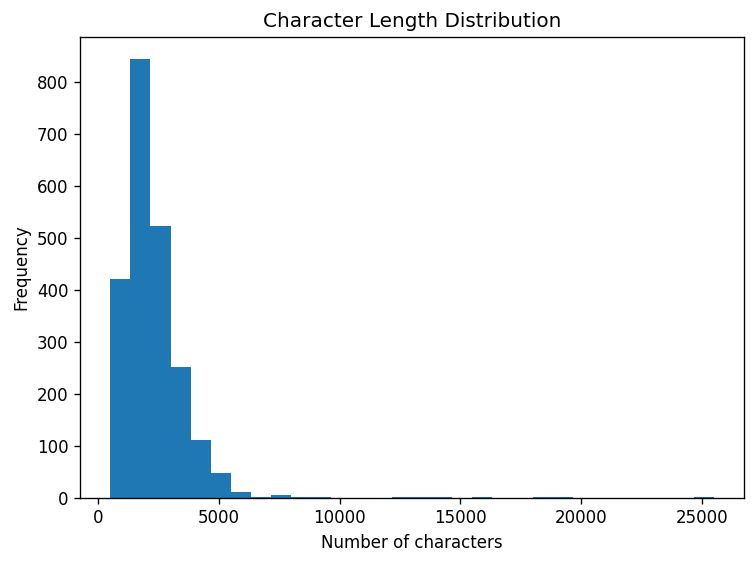

In [9]:
plt.figure()
plt.hist(df["char_len"], bins=30)
plt.title("Character Length Distribution")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Category-wise length comparison
Some topics may systematically use longer/shorter headlines.


In [10]:
grp = df.groupby("labels")["tok_len"].agg(["count", "mean", "median", "min", "max"]).sort_values("mean", ascending=False)
grp


count        mean  median  min   max
labels                                             
tech             401  502.695761   447.0  162  2969
politics         417  453.973621   439.0   89  4432
entertainment    386  330.621762   262.5  143  3482
sport            511  329.262231   288.0  114  1662
business         510  328.880392   297.0  140   891

/tmp/ipykernel_285476/938219721.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories, showfliers=False)


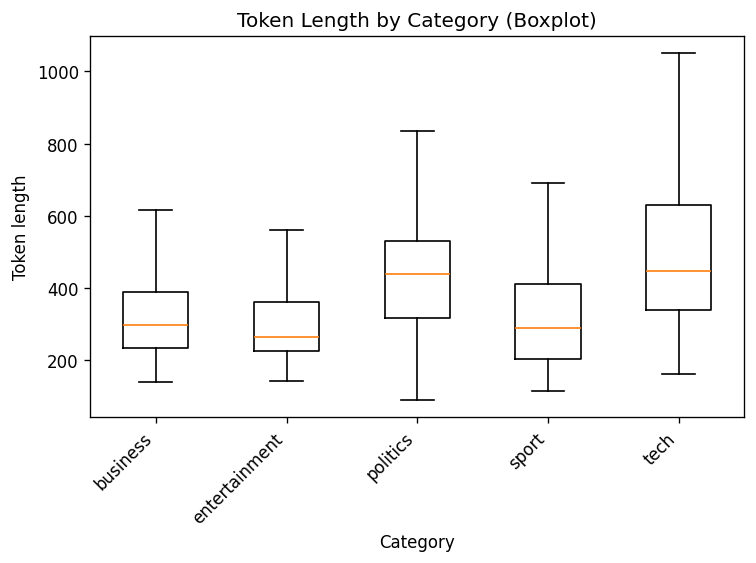

In [11]:
plt.figure()
# Matplotlib boxplot expects data per group
categories = df["labels"].unique().tolist()
data = [df.loc[df["labels"] == c, "tok_len"].values for c in categories]
plt.boxplot(data, labels=categories, showfliers=False)
plt.title("Token Length by Category (Boxplot)")
plt.xlabel("Category")
plt.ylabel("Token length")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 4) Basic Text Cleaning for EDA
For EDA word statistics, we use a light tokenizer:
- lowercase
- keep alphabetic tokens (you can expand if you want)

Note: This is for analysis only; your modeling pipeline may tokenize differently.


In [12]:
def simple_tokenize(text: str):
    text = str(text).lower()
    # keep alphabetic words (and apostrophes within words)
    tokens = re.findall(r"[a-z]+(?:'[a-z]+)?", text)
    return tokens

# quick demo
simple_tokenize("Hello, BBC's markets fall 3% today!")


['hello', "bbc's", 'markets', 'fall', 'today']

## 5) Frequent Words (Overall)
Top words help confirm that the dataset has strong lexical signals.


In [13]:
all_tokens = []
for t in df["text"]:
    all_tokens.extend(simple_tokenize(t))

freq_all = Counter(all_tokens)
freq_all.most_common(20)


[('the', 52636),
 ('to', 25113),
 ('of', 20008),
 ('and', 18612),
 ('a', 18342),
 ('in', 17734),
 ('for', 8945),
 ('is', 8555),
 ('that', 8055),
 ('on', 7624),
 ('said', 7255),
 ('it', 7011),
 ('was', 6028),
 ('be', 5805),
 ('he', 5785),
 ('with', 5354),
 ('as', 4981),
 ('has', 4957),
 ('have', 4772),
 ('at', 4638)]

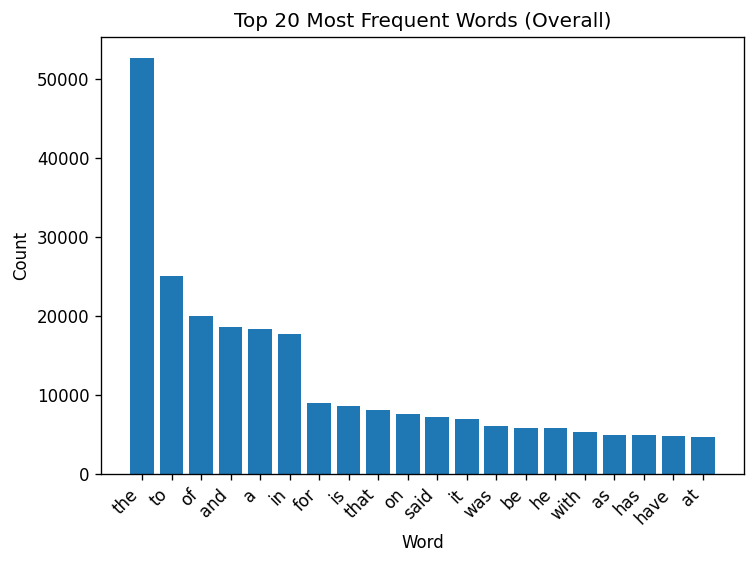

In [14]:
# Plot top-k words
top_k = 20
words, counts = zip(*freq_all.most_common(top_k))

plt.figure()
plt.bar(words, counts)
plt.title(f"Top {top_k} Most Frequent Words (Overall)")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 6) Frequent Words by Category
This is often the most informative EDA for topic classification.

We compute top words per class.


In [15]:
from collections import Counter

def all_words_by_category(df, category_col="labels", text_col="text"):
    out = {}
    for cat in sorted(df[category_col].unique()):
        tokens = []
        sub = df[df[category_col] == cat]
        for t in sub[text_col]:
            tokens.extend(simple_tokenize(t))  # 假设这里已去 stopwords
        out[cat] = Counter(tokens)  # 👈 不用 most_common
    return out


In [16]:
all_words = all_words_by_category(df)


In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

def plot_wordclouds_all_words(all_words, figsize_per_row=(15, 4)):
    cats = list(all_words.keys())
    n = len(cats)

    fig, axes = plt.subplots(
        n, 1,
        figsize=(figsize_per_row[0], figsize_per_row[1] * n)
    )

    # 只有一个类别时，axes 不是 list
    if n == 1:
        axes = [axes]

    for ax, cat in zip(axes, cats):
        freq_dict = dict(all_words[cat])

        wc = WordCloud(
            width=800,
            height=400,
            background_color="white",
            max_words=200,
            collocations=False
        ).generate_from_frequencies(freq_dict)

        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(cat, fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

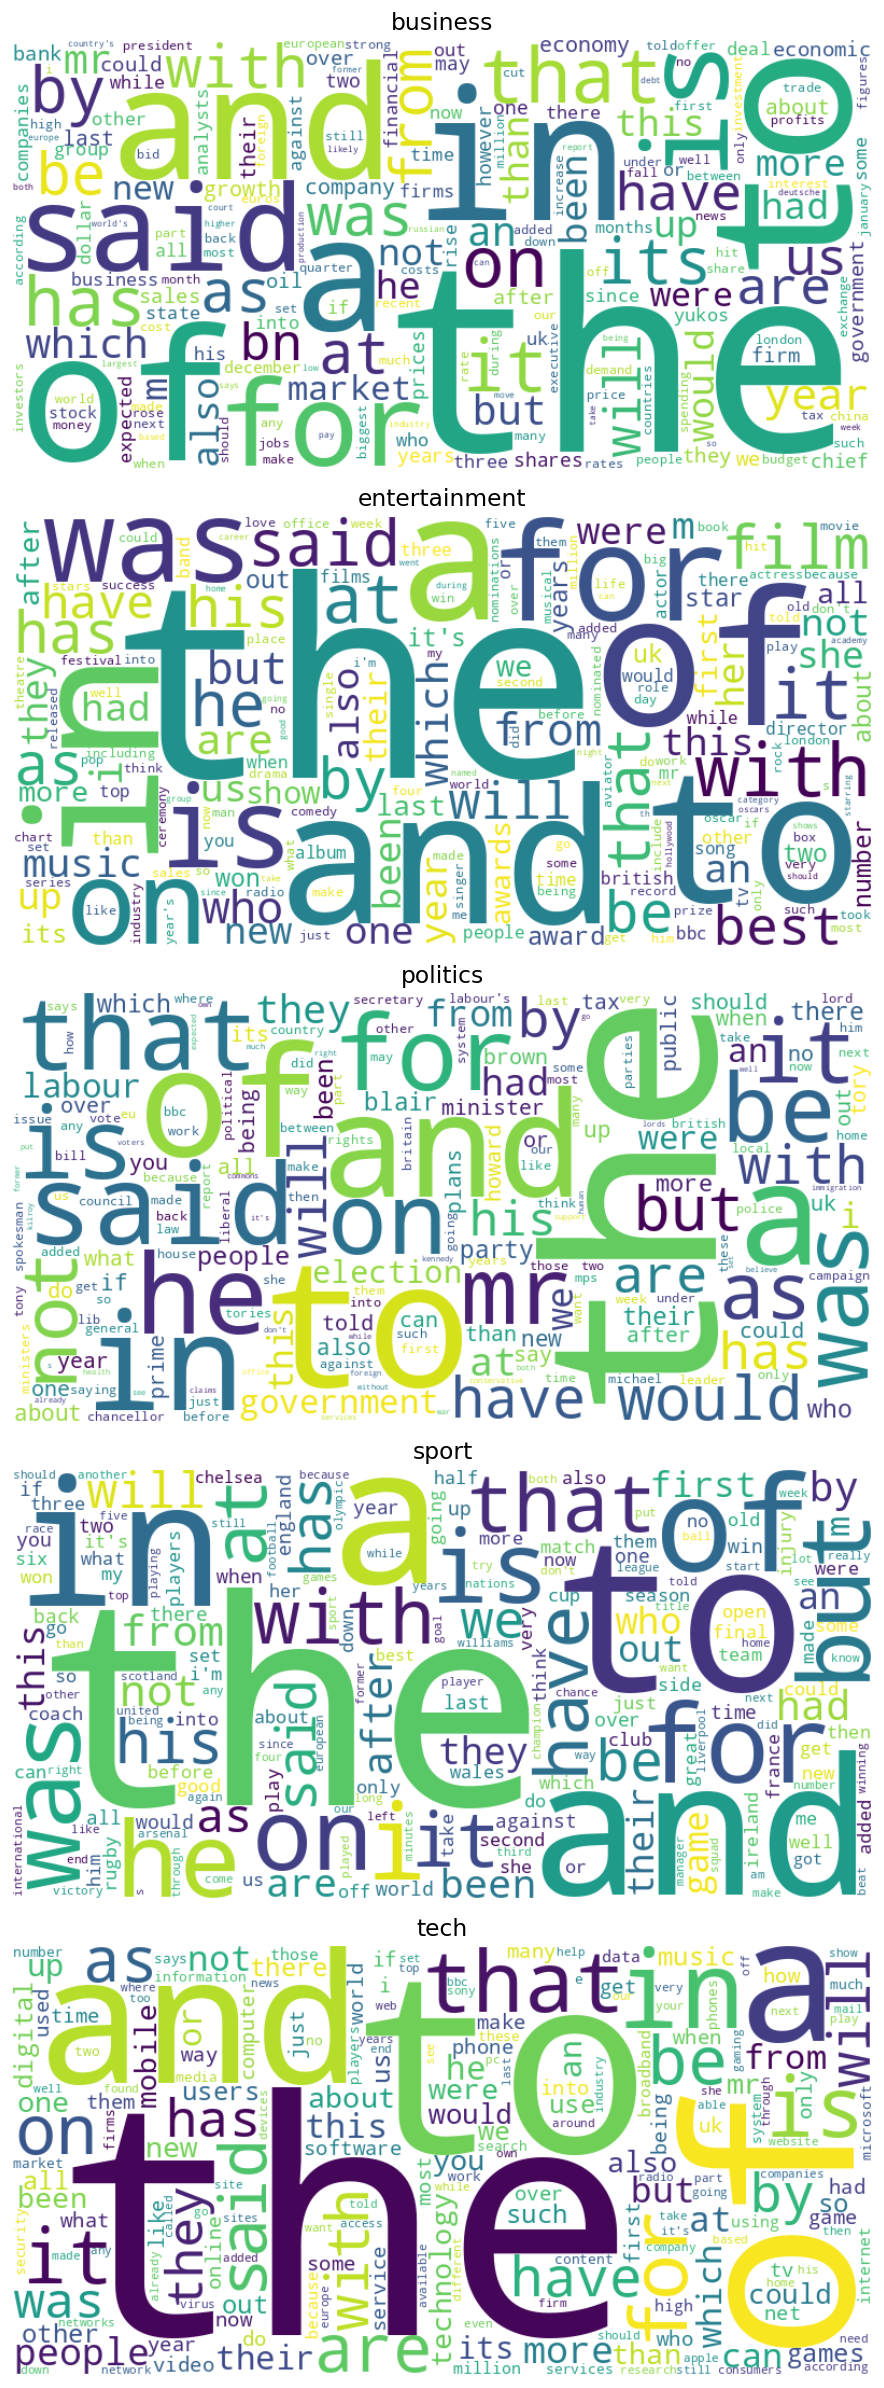

In [18]:
plot_wordclouds_all_words(all_words)


In [19]:
def top_words_by_category(df, category_col="labels", text_col="text", top_k=15):
    out = {}
    for cat in sorted(df[category_col].unique()):
        tokens = []
        sub = df[df[category_col] == cat]
        for t in sub[text_col]:
            tokens.extend(simple_tokenize(t))
        out[cat] = Counter(tokens).most_common(top_k)
    return out

top_by_cat = top_words_by_category(df, top_k=15)
top_by_cat


{'business': [('the', 10819),
  ('to', 5086),
  ('of', 4383),
  ('in', 4332),
  ('a', 3457),
  ('and', 3208),
  ('said', 1680),
  ('for', 1615),
  ('is', 1608),
  ('that', 1584),
  ('it', 1414),
  ('on', 1382),
  ('has', 1252),
  ('its', 1100),
  ('by', 1098)],
 'entertainment': [('the', 8269),
  ('and', 3019),
  ('of', 2973),
  ('to', 2903),
  ('in', 2817),
  ('a', 2749),
  ('for', 1543),
  ('on', 1176),
  ('was', 1140),
  ('is', 1082),
  ('with', 946),
  ('it', 871),
  ('at', 835),
  ('said', 825),
  ('he', 805)],
 'politics': [('the', 12184),
  ('to', 6004),
  ('of', 4471),
  ('and', 3974),
  ('a', 3912),
  ('in', 3396),
  ('said', 2241),
  ('he', 2201),
  ('for', 1920),
  ('that', 1909),
  ('on', 1860),
  ('is', 1837),
  ('mr', 1686),
  ('be', 1676),
  ('was', 1576)],
 'sport': [('the', 9657),
  ('to', 4721),
  ('a', 3867),
  ('and', 3688),
  ('in', 3673),
  ('of', 2817),
  ('for', 1751),
  ('i', 1631),
  ('he', 1629),
  ('on', 1512),
  ('is', 1492),
  ('but', 1450),
  ('was', 1426

In [20]:
# Pretty print
for cat, items in top_by_cat.items():
    print("\n===", cat, "===")
    print(", ".join([f"{w}({c})" for w, c in items]))



=== business ===
the(10819), to(5086), of(4383), in(4332), a(3457), and(3208), said(1680), for(1615), is(1608), that(1584), it(1414), on(1382), has(1252), its(1100), by(1098)

=== entertainment ===
the(8269), and(3019), of(2973), to(2903), in(2817), a(2749), for(1543), on(1176), was(1140), is(1082), with(946), it(871), at(835), said(825), he(805)

=== politics ===
the(12184), to(6004), of(4471), and(3974), a(3912), in(3396), said(2241), he(2201), for(1920), that(1909), on(1860), is(1837), mr(1686), be(1676), was(1576)

=== sport ===
the(9657), to(4721), a(3867), and(3688), in(3673), of(2817), for(1751), i(1631), he(1629), on(1512), is(1492), but(1450), was(1426), that(1219), with(1209)

=== tech ===
the(11707), to(6399), of(5364), and(4723), a(4357), in(3516), that(2595), is(2536), for(2116), it(2074), on(1694), be(1614), are(1576), said(1567), as(1415)


In [21]:
def remove_top_words_per_category(all_words, top_n=20):
    cleaned = {}

    for cat, counter in all_words.items():
        # 取 top-N 高频词
        top_words = {w for w, _ in counter.most_common(top_n)}

        # 过滤掉这些词
        filtered = {
            w: c for w, c in counter.items()
            if w not in top_words
        }

        cleaned[cat] = filtered

    return cleaned


In [22]:
filtered_words = remove_top_words_per_category(all_words, top_n=60)


In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

def plot_wordclouds(filtered_words, figsize_per_row=(15, 4)):
    cats = list(filtered_words.keys())
    n = len(cats)

    fig, axes = plt.subplots(n, 1, figsize=(figsize_per_row[0], figsize_per_row[1] * n))

    # 如果只有一个类别，axes 不是 list
    if n == 1:
        axes = [axes]

    for ax, cat in zip(axes, cats):
        freq_dict = filtered_words[cat]

        wc = WordCloud(
            width=800,
            height=400,
            background_color="white",
            max_words=300,
            min_font_size=6,
            collocations=False
        ).generate_from_frequencies(freq_dict)

        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"{cat} (top words removed)", fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

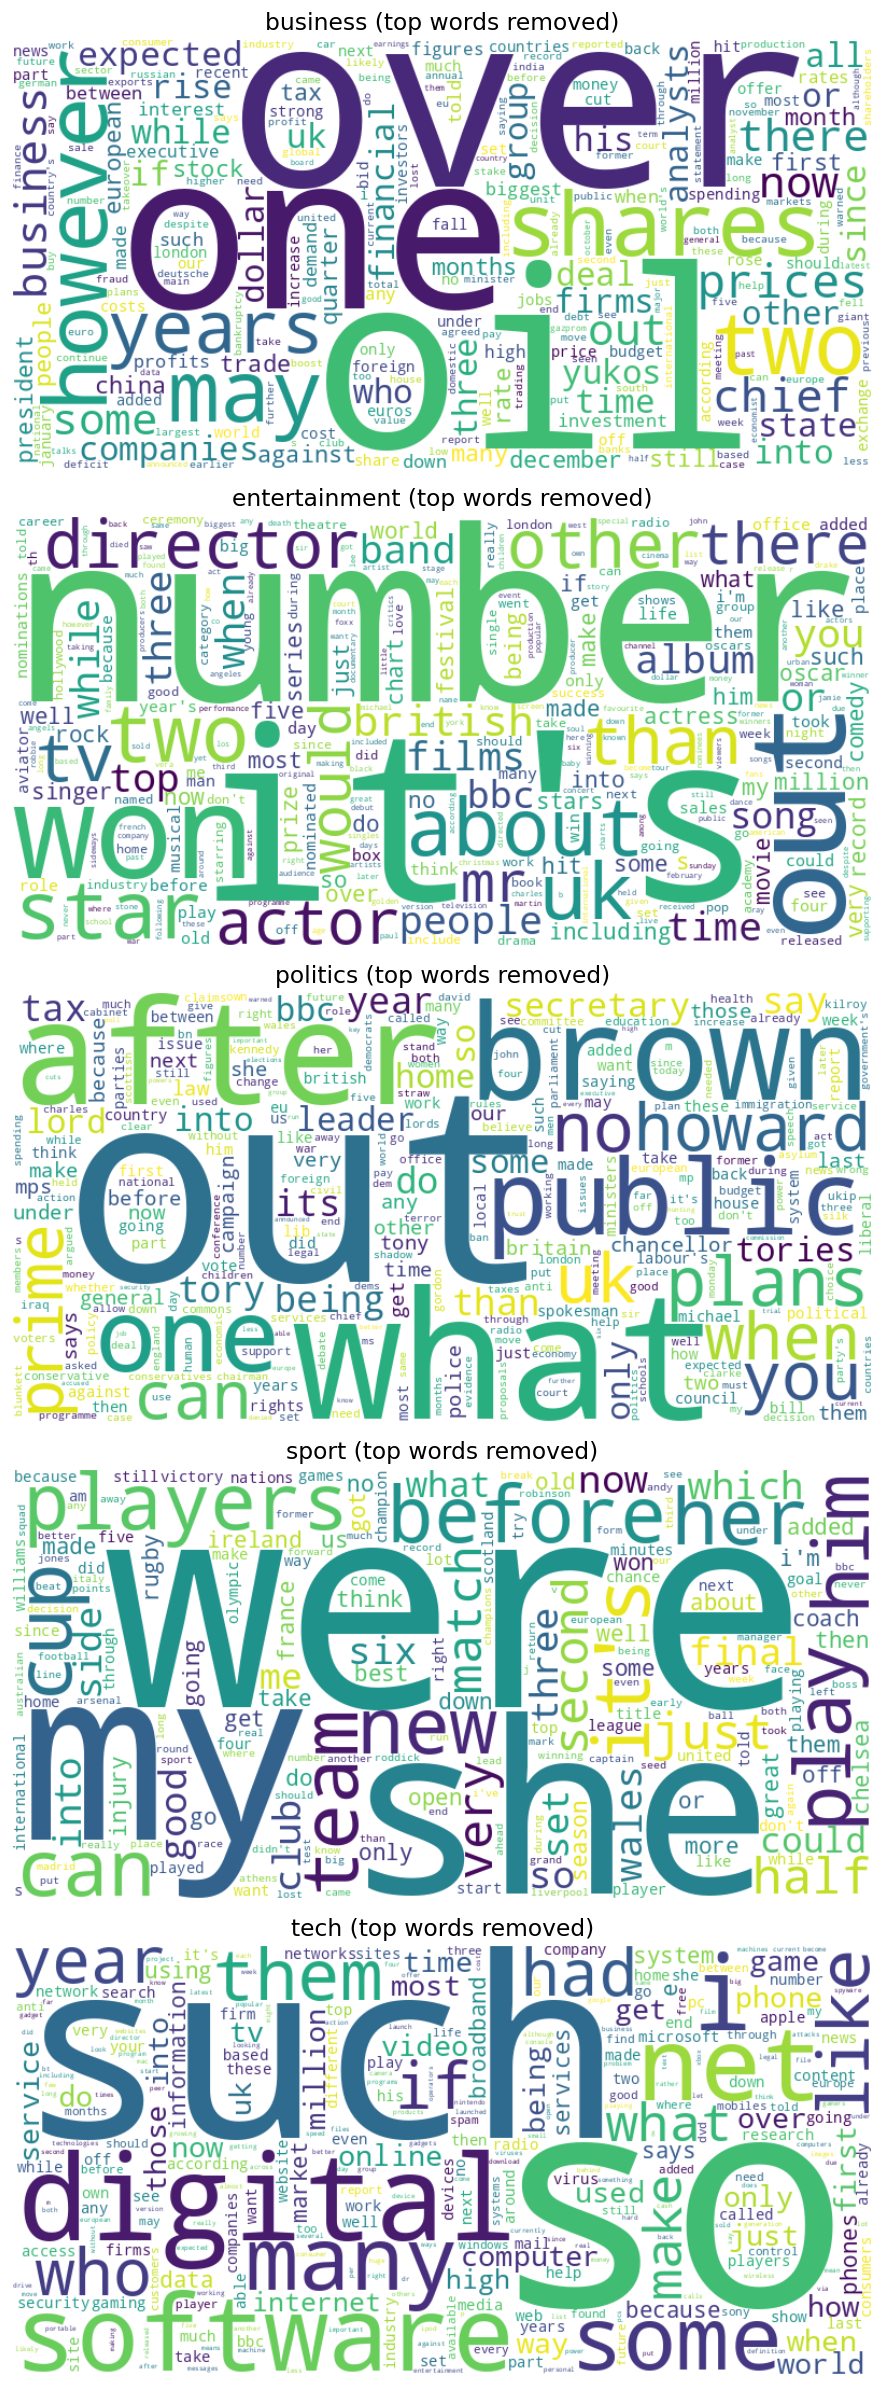

In [24]:
plot_wordclouds(filtered_words)


## 7) Vocabulary Size & Rare Words (OOV intuition)
We quantify how many unique words exist and how many are rare (appear once). A high rare-word rate suggests OOV issues and motivates subword models (e.g., fastText) or robust tokenization.


In [25]:
vocab = set(freq_all.keys())
vocab_size = len(vocab)
n_tokens = sum(freq_all.values())
n_rare = sum(1 for w, c in freq_all.items() if c == 1)
rare_ratio = n_rare / vocab_size if vocab_size else 0

print("Total tokens:", n_tokens)
print("Vocab size:", vocab_size)
print("Rare words (count==1):", n_rare)
print("Rare word ratio:", round(rare_ratio, 4))


Total tokens: 847950
Vocab size: 29503
Rare words (count==1): 10081
Rare word ratio: 0.3417


## 8) n-gram / TF-IDF sanity check (optional)
Since your classical models performed very well, it's useful to record basic TF-IDF stats for reporting: vocabulary size and sparsity.


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2
)

X = vectorizer.fit_transform(df["text"].astype(str))
print("TF-IDF matrix shape:", X.shape)
print("TF-IDF vocab size:", len(vectorizer.vocabulary_))
# sparsity = proportion of zero entries
sparsity = 1.0 - (X.nnz / (X.shape[0] * X.shape[1]))
print("Sparsity:", round(sparsity, 4))


TF-IDF matrix shape: (2225, 77505)
TF-IDF vocab size: 77505
Sparsity: 0.9972


## 9) EDA Summary (write-up template)
Use this section to summarize findings in your report. Fill in numbers from the outputs above.

**Template:**
- The dataset contains N samples across K categories.
- Class distribution is (balanced / slightly imbalanced), with the largest class ... and smallest class ...
- Headlines are short: median token length ..., with most under ... tokens.
- Category-wise, ... tends to be longer/shorter.
- Frequent-word analysis shows distinctive keywords per category, supporting strong lexical signals.
- Vocabulary analysis indicates ...% rare words, suggesting (limited / non-trivial) OOV risk.
- TF-IDF feature space is high-dimensional and sparse (shape ..., sparsity ...), which favors linear models.
